In [42]:
import numpy as np
import pandas as pd
import cv2, os
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
train_data_dir = r"C:\Users\sihus\OneDrive\Desktop\MP DL\split_images_green_notbinary\train"
test_data_dir = r"C:\Users\sihus\OneDrive\Desktop\MP DL\split_images_green_notbinary\test"
pred_data_dir = r"C:\Users\sihus\OneDrive\Desktop\MP DL\split_images_green_notbinary\val"

In [46]:
#Checking the number of Train Images

for i in os.listdir(train_data_dir):
    new_loc = os.path.join(train_data_dir,i)
    new = new_loc + '/*.png'
    images = glob(new)
    print(f'{i}:',len(images))

Abnormal Heartbeat: 163
History of MI: 120
MI: 167
Normal: 198


In [48]:
#Checking the number of Test Images

for i in os.listdir(test_data_dir):
    new_loc = os.path.join(test_data_dir,i)
    new = new_loc + '/*.png'
    images = glob(new)
    print(f'{i}:',len(images))

Abnormal Heartbeat: 36
History of MI: 27
MI: 37
Normal: 44


In [50]:
# Getting the classes and their meaning in a dictionary
classes = os.listdir(train_data_dir)
classes = {k: v for k,v in enumerate(sorted(classes))}
print(classes)

{0: 'Abnormal Heartbeat', 1: 'History of MI', 2: 'MI', 3: 'Normal'}


In [52]:
from PIL import Image

img_path = r"C:\Users\sihus\OneDrive\Desktop\MP DL\split_images_green_notbinary\train\Abnormal Heartbeat\HB(1)_green_channel.png"
img = Image.open(img_path)
print("Original size:", img.size)  # Output: (width, height)


Original size: (2213, 1122)


In [54]:
# Performing the Image Transformation and Data Augmentation on the 
# train dataset and transformation on Validation Dataset

# convert data to a normalized torch.FloatTensor

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.3,0.4,0.4,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.425,0.415,0.405),(0.205,0.205,0.205))
])

# Augmentation on test images not needed
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [56]:
# using ImageFolder function for fetching data from directory
train_data = datasets.ImageFolder(root=train_data_dir,transform=transform)
test_data = datasets.ImageFolder(root=test_data_dir,transform=transform_tests)

training_data = DataLoader(train_data,batch_size=32,drop_last=True,shuffle=True,num_workers=2)
validation_data = DataLoader(test_data, batch_size =32, drop_last=True,shuffle=True,num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 300, 300])
-------------
0
Class:  Abnormal Heartbeat


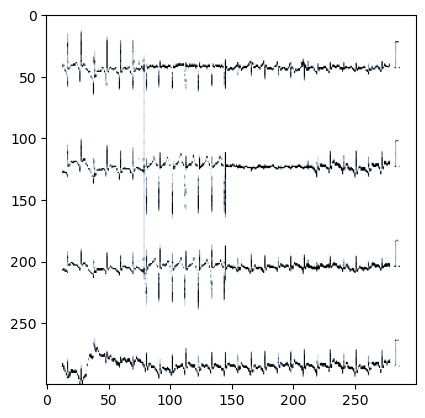

In [58]:
# Random checking of train images
im, label = train_data[10]
print(im.shape)
print("-------------")
print(label)
plt.imshow(im.permute(1,2,0).cpu())
print("Class: ",classes[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: Abnormal Heartbeat


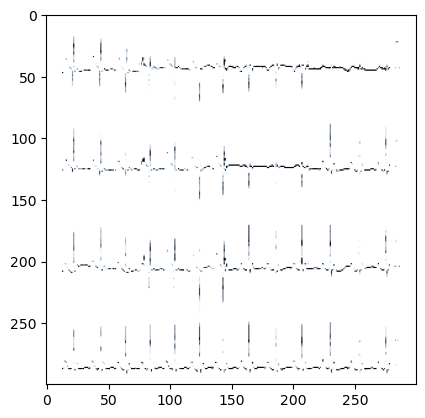

In [60]:
im, label = train_data[55]
plt.imshow(im.permute(1,2,0).cpu())
print('Class:',classes[label])

In [62]:
#Downloading the InceptionV3 Model with their pretrained weights

model = models.inception_v3(pretrained=True)
model.parameters

<bound method Module.parameters of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2

In [64]:
#Defining the Model Function.

def get_model():
    model = models.inception_v3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128,4))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [66]:
from torchsummary import summary

input_shape = (3,300,300)
summary(model.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [68]:
#Creating the Utlity function to get the Losses and Accuracies for Train and Validation Dataset 

def train_batch(x, y, model, opt, loss_fn):
    output = model(x)
#     print(f"type of output - {type(output)}")
    batch_loss = loss_fn(output, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [70]:
model, loss_fn, optimizer = get_model()

In [72]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_accuracy = 0.0  # or use float('inf') for lowest val loss
best_model_path = "best_model_inception_greenimagesnotbinary.pth"

for epoch in range(51):
    print(f"\nEpoch {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []

    # Training loop
    for ix, batch in enumerate(iter(training_data)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
        train_epoch_losses.append(batch_loss)
    
    train_epoch_loss = np.mean(train_epoch_losses)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print('Train Loss:', train_epoch_loss, 'Train Accuracy:', train_epoch_accuracy)

    # Validation loop
    val_epoch_losses, val_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(validation_data)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        val_epoch_losses.append(validation_loss)
        val_epoch_accuracies.extend(val_is_correct)

    val_epoch_loss = np.mean(val_epoch_losses)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    print('Validation Loss:', val_epoch_loss, 'Validation Accuracy:', val_epoch_accuracy)

    # Save metrics
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Save best model
    if val_epoch_accuracy > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")
        


Epoch 0
Train Loss: 1.2617170691490174 Train Accuracy: 0.4171875
Validation Loss: 1.0976736843585968 Validation Accuracy: 0.5390625
Best model saved with accuracy: 0.5391

Epoch 1
Train Loss: 1.024825644493103 Train Accuracy: 0.5578125
Validation Loss: 1.002221941947937 Validation Accuracy: 0.6171875
Best model saved with accuracy: 0.6172

Epoch 2
Train Loss: 0.9450732231140136 Train Accuracy: 0.615625
Validation Loss: 0.9879329055547714 Validation Accuracy: 0.6171875

Epoch 3
Train Loss: 0.8580722212791443 Train Accuracy: 0.653125
Validation Loss: 0.9340762943029404 Validation Accuracy: 0.5546875

Epoch 4
Train Loss: 0.7908817559480668 Train Accuracy: 0.7171875
Validation Loss: 0.746135950088501 Validation Accuracy: 0.7109375
Best model saved with accuracy: 0.7109

Epoch 5
Train Loss: 0.711569944024086 Train Accuracy: 0.7375
Validation Loss: 0.8104603886604309 Validation Accuracy: 0.6796875

Epoch 6
Train Loss: 0.6814882457256317 Train Accuracy: 0.734375
Validation Loss: 0.8037430346

In [74]:
print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")

Best model saved with accuracy: 0.8750


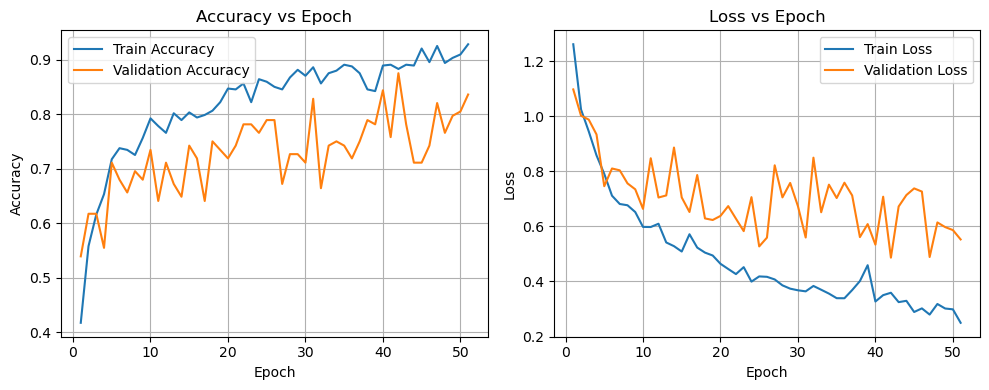

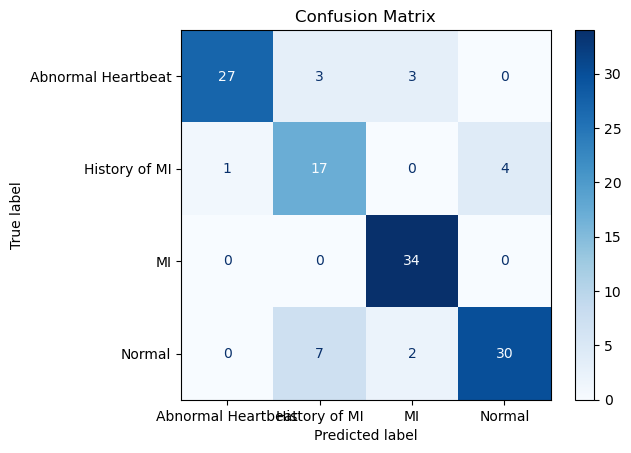

Classification Report:
                    precision    recall  f1-score   support

Abnormal Heartbeat       0.96      0.82      0.89        33
     History of MI       0.63      0.77      0.69        22
                MI       0.87      1.00      0.93        34
            Normal       0.88      0.77      0.82        39

          accuracy                           0.84       128
         macro avg       0.84      0.84      0.83       128
      weighted avg       0.86      0.84      0.85       128



In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
classes = ['Abnormal Heartbeat', 'History of MI', 'MI', 'Normal']

# 1. Accuracy vs Epoch
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True)

# 2. Loss vs Epoch
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Confusion Matrix on Validation Set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in validation_data:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        predicted = torch.argmax(preds, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# Create the ConfusionMatrixDisplay object and pass the class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 4. Classification Report
print("Classification Report:")
# Ensure 'classes' is a list of strings representing your class names
print(classification_report(all_labels, all_preds, target_names=classes))


In [80]:
#Function to predict the images from prediction set

from torch.autograd import Variable

def pred_class(img):
    # transform images
    img_tens = transform_tests(img)
    # change image format (3,300,300) to (1,3,300,300) by help of unsqueeze function
    # image needs to be in cuda before prediction
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()    
    return index

Total prediction files: 136
First 10 prediction files: ['C:\\Users\\sihus\\OneDrive\\Desktop\\MP DL\\split_images_green_notbinary\\val\\Abnormal Heartbeat\\HB(109)_green_channel.png', 'C:\\Users\\sihus\\OneDrive\\Desktop\\MP DL\\split_images_green_notbinary\\val\\Abnormal Heartbeat\\HB(114)_green_channel.png', 'C:\\Users\\sihus\\OneDrive\\Desktop\\MP DL\\split_images_green_notbinary\\val\\Abnormal Heartbeat\\HB(117)_green_channel.png', 'C:\\Users\\sihus\\OneDrive\\Desktop\\MP DL\\split_images_green_notbinary\\val\\Abnormal Heartbeat\\HB(120)_green_channel.png', 'C:\\Users\\sihus\\OneDrive\\Desktop\\MP DL\\split_images_green_notbinary\\val\\Abnormal Heartbeat\\HB(127)_green_channel.png', 'C:\\Users\\sihus\\OneDrive\\Desktop\\MP DL\\split_images_green_notbinary\\val\\Abnormal Heartbeat\\HB(134)_green_channel.png', 'C:\\Users\\sihus\\OneDrive\\Desktop\\MP DL\\split_images_green_notbinary\\val\\Abnormal Heartbeat\\HB(135)_green_channel.png', 'C:\\Users\\sihus\\OneDrive\\Desktop\\MP DL\\spl

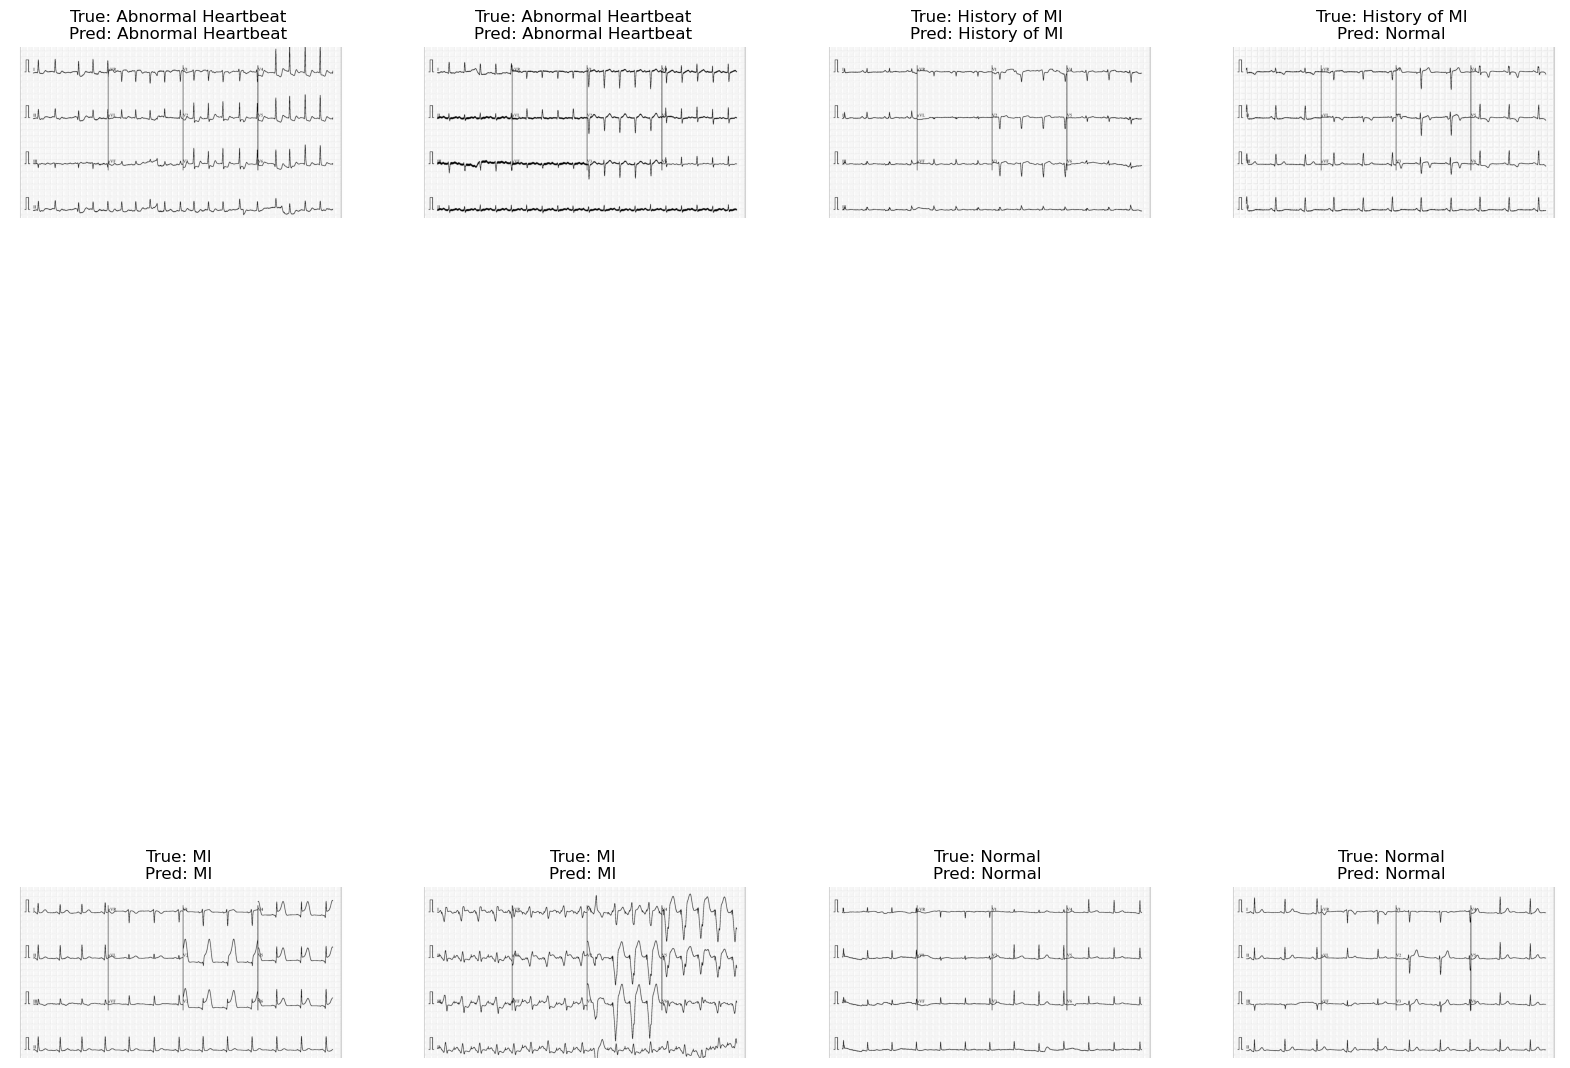

In [82]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to the folder containing subfolders with images
pred_data_dir = r"C:\Users\sihus\OneDrive\Desktop\MP DL\split_images_green_notbinary\val"

# List image files in all subdirectories
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
pred_files = []

# Walk through the subdirectories and collect image files
for root, dirs, files in os.walk(pred_data_dir):
    for f in files:
        if f.lower().endswith(tuple(image_extensions)):  # Check for image extensions
            pred_files.append(os.path.join(root, f))

# Print the first 10 files to verify
print(f"Total prediction files: {len(pred_files)}")
print(f"First 10 prediction files: {pred_files[:10]}")

# Ensure the model is in evaluation mode
model.eval()

# Set up the plot
plt.figure(figsize=(20, 20))

# Create a list to store the selected images from each class
selected_images = []

# Loop through the directories (classes) and select images from each class
class_names = os.listdir(pred_data_dir)  # Get the class names (subfolder names)
for class_name in class_names:
    class_path = os.path.join(pred_data_dir, class_name)
    if os.path.isdir(class_path):
        # Select the first 2 images from each class folder (you can adjust the number of images)
        class_images = [os.path.join(class_path, f) for f in os.listdir(class_path) 
                        if f.lower().endswith(tuple(image_extensions))][:2]
        selected_images.extend(class_images)

# Print selected images for debugging
print(f"Selected images: {selected_images}")

# Loop through the selected images and display the true vs predicted labels
for i, image_path in enumerate(selected_images[:8]):  # Limiting to first 8 images
    try:
        # Open and display the image
        img = Image.open(image_path)
        
        # Extract the true label from the folder name
        true_label = os.path.basename(os.path.dirname(image_path))  # Folder name is the true label
        
        # Perform prediction
        index = pred_class(img)  
        predicted_label = classes[index]  
        
        # Plot the image with true and predicted labels
        plt.subplot(2, 4, i+1)  # Arrange images in 2 rows and 4 columns
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
        plt.imshow(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        continue

# Show the plot with the images
plt.show()
